# 0. Setting Up The Data

In [1]:
pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: joblib━━━━━━━━━━━━━━━━━━ 0/7 [numpy]
    Found existing installation: joblib 1.4.2 0/7 [numpy]
    Uninstalling joblib-1.4.2:━━━━━━━━━━━━━━ 0/7 [numpy]
      Successfully uninstalled joblib-1.4.2━ 0/7 [numpy]
  Attempting uninstall: scipy90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/7 [joblib]
    Found existing installation: scipy 1.15.3━━━━━━━━━━━━━━━━━ 1/7 [joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# read dataframe from local file
df_groups = pd.read_csv('drone_prod_groups.csv')
df_groups

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,99997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99997,99998,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
99998,99999,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [3]:
df_loc = pd.read_csv('drone_cust_locations.csv', sep=';')

# 1. Business Understanding

The primary goal is to use clustering techniques such as kNN to optimize the location of drone hubs or depots for customer deliveries. By grouping customers based on geographic proximity, the company can determine efficient depot locations that minimize travel distance and improve operational performance.

In addition, association rule mining will be used to identify relationships between product groups that are frequently purchased together. These insights can support targeted marketing, product recommendations, and cross-selling strategies to increase overall revenue.

# 2. Data Understanding

In [4]:
print('Customer location data shape:', df_loc.shape)
print('Product transactions data shape:', df_groups.shape)
print('\nCustomer columns:', df_loc.columns.tolist())
print('Product columns:', df_groups.columns.tolist()[:5], '...')

Customer location data shape: (5956, 3)
Product transactions data shape: (100000, 21)

Customer columns: ['clientid', 'x', 'y']
Product columns: ['ID', 'Prod1', ' Prod2', ' Prod3', ' Prod4'] ...


In [5]:
df_loc.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


In [6]:
df_groups.head()

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


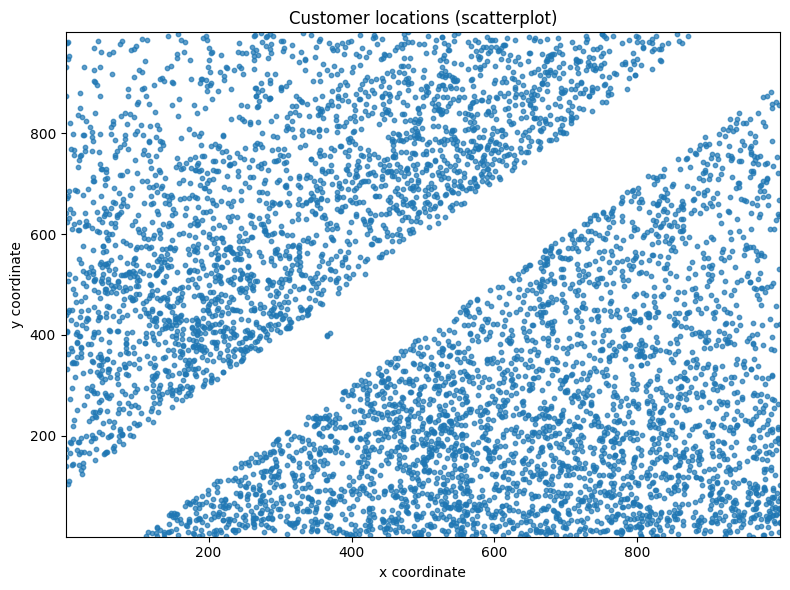

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_loc["x"], df_loc["y"], s=10, alpha=0.7)
plt.title("Customer locations (scatterplot)")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.xlim(df_loc["x"].min(), df_loc["x"].max())
plt.ylim(df_loc["y"].min(), df_loc["y"].max())
plt.tight_layout()
plt.show()

The Customer Density plot reveals two major populated regions separated by a clear unpopulated gap. This suggests a geographical or infrastructural barrier such as a river dividing the customer base into two distinct service areas.

# 3. Data Preparation

## Part 1: Customer locations

For clustering we will use the `x` and `y` coordinates as features excluding the `clientid` as it does not contain any relevant information for clustering.

Since both `x` and `y` are measured in the same distance scale, no further feature scaling is required.

In [8]:
X = df_loc[["x", "y"]].copy()
X.head()

,x,y
0,622.771572,164.857623
1,416.357298,630.193634
2,292.735020,567.333231
3,737.211288,166.225676
4,540.475375,682.912298


## Part 2: Products

Dataset is otherwise clean and sufficient.  
Only necessary modification is dropping the "ID" column as well as converting numerical values to boolean.  

In [9]:
df_groups = df_groups.drop(columns='ID')
df_groups = df_groups.apply(lambda x: x.map(lambda y: True if y == 1.0 else False))
df_groups

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
99997,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
99998,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True


Due to the large number of categories the minimum support needs to be set sufficiently low to find any results from the dataset.  
Sufficient minimum support was determined manually by gradually reducing the value from a starting point of 10%. 
At 3% the results display a first itemset of three products with 38 individual itemsets and at 2.5% provides four different itemsets of three with only 59 individual itemsets.  
At this level the results are still manageable enough for a quick human analysis.  

However due to the large sample size of the data, as well as its sizeable number of categories it is worth it to push the minimum support even lower for further item combinations.  

At 0.01% the code execution time begins to suffer and the size of the result set increases to 10080. More than 10% of the original sample size. At this point the findings become too expansive to indicate anything meaningful, so 0.01% can be considered the lower limit.  

At 0.15% the result set is 1081, 1% of the original sample size, and yields an instance of itemset with 6 products.  
For that reason it is deemed the acceptable minimum for support.  

In [10]:
frequent_itemsets = apriori(df_groups, min_support=0.0015, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,frozenset({Prod1})
1,0.13098,frozenset({ Prod2})
2,0.03271,frozenset({ Prod3})
3,0.03585,frozenset({ Prod4})
4,0.10459,frozenset({ Prod5})
...,...,...
1077,0.00358,"frozenset({ Prod9, Prod15, Prod19, Prod20, ..."
1078,0.00359,"frozenset({ Prod9, Prod15, Prod19, Prod16, ..."
1079,0.00154,"frozenset({ Prod9, Prod15, Prod17, Prod19, ..."
1080,0.00325,"frozenset({ Prod9, Prod18, Prod15, Prod19, ..."


# 4. Modeling

## Part 1: Depot placement with clustering

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans, AgglomerativeClustering


def run_clustering(data, n_clusters, method="kmeans"):
    start = time.perf_counter()

    if method == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        labels = model.fit_predict(data)
        hubs = pd.DataFrame(model.cluster_centers_, columns=['x', 'y'])
        hubs['depot_id'] = hubs.index
    elif method == "hierarchical":
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(data)
        hubs = None  # will compute outside
    else:
        raise ValueError("Unsupported method. Use 'kmeans' or 'hierarchical'.")

    duration = time.perf_counter() - start

    return model, labels, hubs, duration


def attach_depot_labels(original_df, labels, label_col='nearest_depot'):
    out = original_df.copy()
    out[label_col] = labels
    return out


def plot_results(data, hubs, model):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='x', y='y', hue='nearest_depot', palette='tab10', s=18, alpha=0.7, legend=False)
    plt.scatter(hubs['x'], hubs['y'], c='white', s=140, marker='X', label='Depots')
    plt.title(f'{model} clustering (k={K})')
    plt.show()

### K-means clustering

In [12]:
K = 3  # number of depots

kmeans_3, labels_3, hubs_3, t_3 = run_clustering(X, n_clusters=K)
assigned_3 = attach_depot_labels(df_loc, labels_3)

print(f'K-means runtime (k={K}): {t_3:.4f} seconds')
print(f'Depot coordinates (k={K}):')
print(hubs_3)

K-means runtime (k=3): 0.1171 seconds
Depot coordinates (k=3):
            x           y  depot_id
0  194.409092  393.312949         0
1  697.395271  210.101185         1
2  554.215782  787.789998         2


In [13]:
# First 10 rows with nearest depot attached
assigned_3.head(10)

,clientid,x,y,nearest_depot
0,1,622.771572,164.857623,1
1,2,416.357298,630.193634,2
2,3,292.735020,567.333231,0
3,4,737.211288,166.225676,1
4,5,540.475375,682.912298,2
5,6,535.469492,318.439661,1
6,7,640.380050,870.833221,2
7,8,235.772075,359.048203,0
8,9,481.896884,661.491838,2
9,10,730.032789,312.177817,1


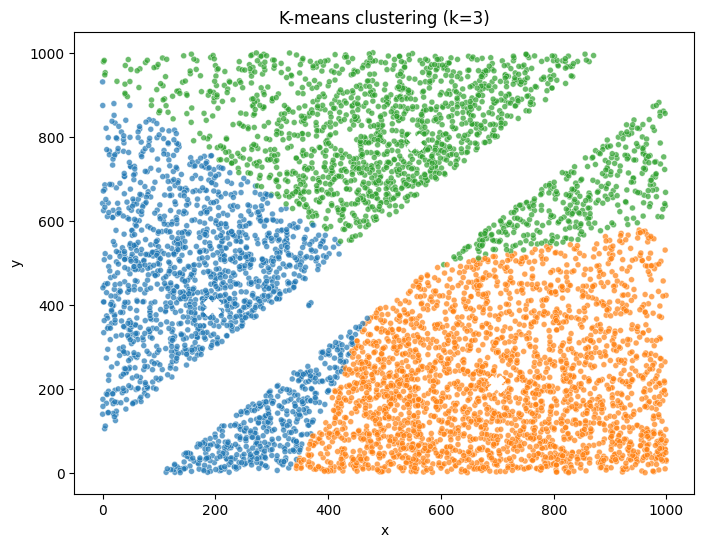

In [14]:
plot_results(data=assigned_3, hubs=hubs_3, model='K-means')

Using the K-means clustering (K = 3), hubs are located centrally inside dense customer areas.

K-means runtime (k=10): 0.1421 seconds
Depot coordinates (k=10):
            x           y  depot_id
0  740.535257  406.737399         0
1  311.368096   86.879142         1
2  199.977511  529.523405         2
3  626.473229  894.336684         3
4  549.663150  174.824021         4
5  849.995142  127.937289         5
6  882.453954  642.829205         6
7  107.647002  329.970402         7
8  449.394909  728.170972         8
9  186.942213  835.914295         9


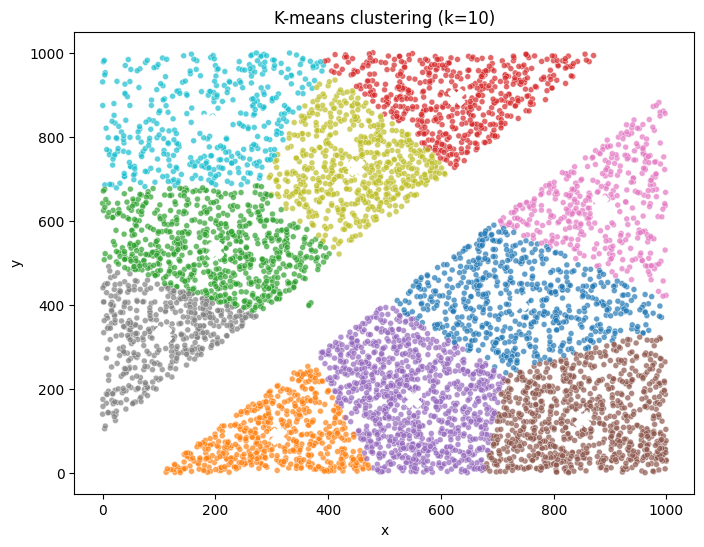

In [15]:
K = 10
# K-means example for 10 depots
kmeans_10, labels_10, hubs_10, t_10 = run_clustering(X, n_clusters=K)
assigned_10 = attach_depot_labels(df_loc, labels_10)

print(f'K-means runtime (k=10): {t_10:.4f} seconds')
print('Depot coordinates (k=10):')
print(hubs_10)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=assigned_10, x='x', y='y', hue='nearest_depot', palette='tab10', s=18, alpha=0.7, legend=False)
plt.scatter(hubs_10['x'], hubs_10['y'], c='white', s=140, marker='X')
plt.title(f'K-means clustering (k={K})')
plt.show()

### Hierarchical clustering

Hierarchical runtime (k=3): 0.2309 seconds
Hierarchical depot coordinates (k=3):
   depot_id           x           y
0         0  607.735321  151.226451
1         1  709.978549  687.401536
2         2  218.178835  578.471885


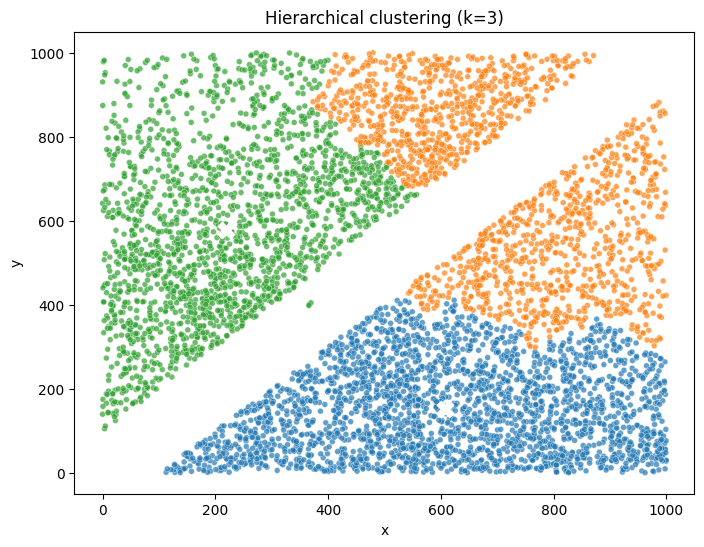

In [16]:
K = 3
hier_3, h_labels_3, _, t_h3 = run_clustering(X, n_clusters=K, method="hierarchical")
assigned_h3 = attach_depot_labels(df_loc, h_labels_3, label_col='nearest_depot')

# Compute hierarchical "hubs" as centroid (mean x/y) of each cluster
hubs_h3 = (
    assigned_h3
    .groupby('nearest_depot', sort=True)[['x', 'y']]
    .mean()
    .reset_index()
    .rename(columns={'nearest_depot': 'depot_id'})
)

# Compute hierarchical "hubs" as centroid (mean x/y) of each cluster
print(f'Hierarchical runtime (k={K}): {t_h3:.4f} seconds')
print(f'Hierarchical depot coordinates (k={K}):')
print(hubs_h3)

plot_results(data=assigned_h3, hubs=hubs_h3, model="Hierarchical")

Using the Hierarchical clustering (K = 3), hubs do not sit perfectly in the densest parts of their regions like in K-means clustering. One of the hubs appears to be placed in the middle of the empty corridor, which makes the K-means clustering locations look more realistic compared to Hierarchical clustering locations.

Hierarchical runtime (k=10): 0.2322 seconds
Hierarchical depot coordinates (k=10):
   depot_id           x           y
0         0  338.327412  590.553869
1         1  381.060391   86.926094
2         2  115.986436  651.602692
3         3  820.723581  130.544730
4         4  591.929165  863.838825
5         5  121.831906  346.097005
6         6  566.646129  255.560723
7         7  778.172733  461.790053
8         8  257.277315  896.239246
9         9  887.259550  679.077475


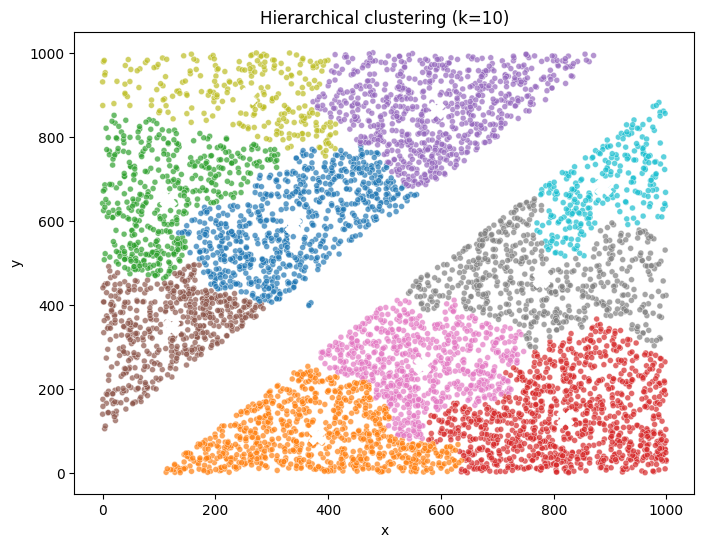

In [17]:
K = 10
# Hierarchical clustering example for 10 depots
hier_10, h_labels_10, _, t_h10 = run_clustering(X, n_clusters=K, method="hierarchical")
assigned_h10 = attach_depot_labels(df_loc, h_labels_10, label_col='nearest_depot')

# Compute hierarchical "hubs" as centroid (mean x/y) of each cluster
hubs_h10 = (
    assigned_h10
    .groupby('nearest_depot', sort=True)[['x', 'y']]
    .mean()
    .reset_index()
    .rename(columns={'nearest_depot': 'depot_id'})
)

print(f'Hierarchical runtime (k=10): {t_h10:.4f} seconds')
print('Hierarchical depot coordinates (k=10):')
print(hubs_h10)

# Plot hierarchical clustering results
plot_results(data=assigned_h10, hubs=hubs_h10, model="Hierarchical")

## Part 2:

Due to the relatively wide angle approach in determining support for the itemsets of the products it would be prudent to use a high threshold for confidence to increase the chances that the relation between the items is genuine.  
Minimum confidence thresholds at values 70%, 80% and 90% provide a very similiar result size of 241 (at 90%) and 284 (at 70%).  
In addition the products 9 and 19 or their combined set appear consistently as the consequent products in these ranges
Choosing the middlepoint value at 80% seems like a good cautious choice.

In [18]:
rules_70 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.70)
rules_80 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.80)
rules_90 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.90)

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.80)

rules = rules.sort_values(by='confidence', ascending=False)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
223,"frozenset({ Prod5, Prod16, Prod12, Prod15})",frozenset({ Prod9}),0.00171,0.19853,0.00168,0.982456,4.948653,1.0,0.001341,45.683790,0.799292,0.008461,0.978110,0.495459
173,"frozenset({ Prod17, Prod15, Prod20})",frozenset({ Prod9}),0.00172,0.19853,0.00167,0.970930,4.890597,1.0,0.001329,27.570568,0.796897,0.008410,0.963729,0.489671
72,"frozenset({ Prod16, Prod2, Prod15})",frozenset({ Prod9}),0.00360,0.19853,0.00349,0.969444,4.883113,1.0,0.002775,26.229927,0.798086,0.017569,0.961876,0.493512
261,"frozenset({ Prod17, Prod15, Prod19, Prod20})",frozenset({ Prod9}),0.00159,0.19853,0.00154,0.968553,4.878625,1.0,0.001224,25.486746,0.796290,0.007755,0.960764,0.488155
267,"frozenset({ Prod12, Prod5, Prod15, Prod19, ...",frozenset({ Prod9}),0.00183,0.19853,0.00177,0.967213,4.871874,1.0,0.001407,24.444835,0.796197,0.008913,0.959092,0.488064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,"frozenset({ Prod15, Prod20})","frozenset({ Prod19, Prod9})",0.02241,0.04996,0.01919,0.856314,17.139995,1.0,0.018070,6.611924,0.963243,0.360850,0.848758,0.620211
217,"frozenset({ Prod2, Prod15, Prod20})","frozenset({ Prod19, Prod9})",0.00401,0.04996,0.00343,0.855362,17.120929,1.0,0.003230,6.568380,0.945383,0.067867,0.847755,0.462008
243,"frozenset({ Prod8, Prod15, Prod20})","frozenset({ Prod19, Prod9})",0.00484,0.04996,0.00412,0.851240,17.038424,1.0,0.003878,6.386380,0.945887,0.081294,0.843417,0.466853
256,"frozenset({ Prod14, Prod15, Prod20})","frozenset({ Prod19, Prod9})",0.00421,0.04996,0.00358,0.850356,17.020742,1.0,0.003370,6.348680,0.945228,0.070765,0.842487,0.461007


In [19]:
print('Threshold set at 70: ')
rules_70['consequents'].unique()

Threshold set at 70: 


array([frozenset({' Prod9'}), frozenset({' Prod19'}),
       frozenset({' Prod12'}), frozenset({' Prod20'}),
       frozenset({' Prod19', ' Prod9'})], dtype=object)

In [ ]:
print('Threshold set at 80: ')
rules_80['consequents'].unique()

Threshold set at 80: 


array([frozenset({' Prod9'}), frozenset({' Prod19'}),
       frozenset({' Prod19', ' Prod9'})], dtype=object)

In [21]:
print('Threshold set at 90: ')
rules_90['consequents'].unique()

Threshold set at 90: 


array([frozenset({' Prod9'}), frozenset({' Prod19'})], dtype=object)

In [22]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2)

rules = rules.sort_values(by='lift', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2898,"frozenset({ Prod19, Prod9, Prod12})","frozenset({ Prod5, Prod15, Prod20})",0.01042,0.00301,0.00177,0.169866,56.433768,1.0,0.001739,1.200998,0.992623,0.151801,0.167359,0.378953
2913,"frozenset({ Prod5, Prod15, Prod20})","frozenset({ Prod19, Prod9, Prod12})",0.00301,0.01042,0.00177,0.588040,56.433768,1.0,0.001739,2.402126,0.985246,0.151801,0.583702,0.378953
2902,"frozenset({ Prod5, Prod9, Prod20})","frozenset({ Prod19, Prod12, Prod15})",0.00513,0.00625,0.00177,0.345029,55.204678,1.0,0.001738,1.517243,0.986949,0.184183,0.340910,0.314115
2909,"frozenset({ Prod19, Prod12, Prod15})","frozenset({ Prod5, Prod9, Prod20})",0.00625,0.00513,0.00177,0.283200,55.204678,1.0,0.001738,1.387932,0.988061,0.184183,0.279504,0.314115
2901,"frozenset({ Prod19, Prod5, Prod9})","frozenset({ Prod12, Prod15, Prod20})",0.00700,0.00465,0.00177,0.252857,54.377880,1.0,0.001737,1.332208,0.988530,0.179150,0.249367,0.316751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,frozenset({ Prod5}),"frozenset({ Prod2, Prod12, Prod15})",0.10459,0.00428,0.00160,0.015298,3.574259,1.0,0.001152,1.011189,0.804349,0.014916,0.011065,0.194565
891,"frozenset({ Prod8, Prod12, Prod15})",frozenset({ Prod5}),0.00496,0.10459,0.00185,0.372984,3.566152,1.0,0.001331,1.428049,0.723173,0.017177,0.299744,0.195336
896,frozenset({ Prod5}),"frozenset({ Prod8, Prod12, Prod15})",0.10459,0.00496,0.00185,0.017688,3.566152,1.0,0.001331,1.012957,0.803638,0.017177,0.012792,0.195336
867,"frozenset({ Prod10, Prod12, Prod8})",frozenset({ Prod5}),0.00440,0.10459,0.00162,0.368182,3.520239,1.0,0.001160,1.417196,0.719092,0.015088,0.294381,0.191835


# 5. Evaluation

## K-means vs Hierarchical clustering evaluation

### Comparing runtime of multiple K values

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

k_values = [2, 3, 4, 5, 6, 8, 10, 12]


def summarize_clustering(method, k_values):
    rows = []
    for k in k_values:
        model, labels, hubs, runtime = run_clustering(X, n_clusters=k, method=method)
        row = {
            "k": k,
            "runtime_sec": runtime,
            "silhouette": silhouette_score(X, labels) if k > 1 else np.nan,
        }
        if method == "kmeans":
            row["inertia"] = model.inertia_
        rows.append(row)
    return pd.DataFrame(rows)


kmeans_results = summarize_clustering("kmeans", k_values)
hier_results = summarize_clustering("hierarchical", k_values)

display(kmeans_results)
display(hier_results)

,k,runtime_sec,silhouette,inertia
0,2,0.049472,0.423128,5.184120e+08
1,3,0.069981,0.423132,3.289215e+08
2,4,0.087609,0.402808,2.343464e+08
3,5,0.078972,0.418362,1.785819e+08
4,6,0.114325,0.399310,1.463363e+08
5,8,0.102922,0.388273,1.103295e+08
6,10,0.135089,0.368032,8.728380e+07
7,12,0.130521,0.376685,7.136498e+07


,k,runtime_sec,silhouette
0,2,0.226787,0.370875
1,3,0.220183,0.405465
2,4,0.232620,0.359196
3,5,0.223711,0.367585
4,6,0.221103,0.341592
5,8,0.218162,0.349919
6,10,0.219039,0.340533
7,12,0.225438,0.322492


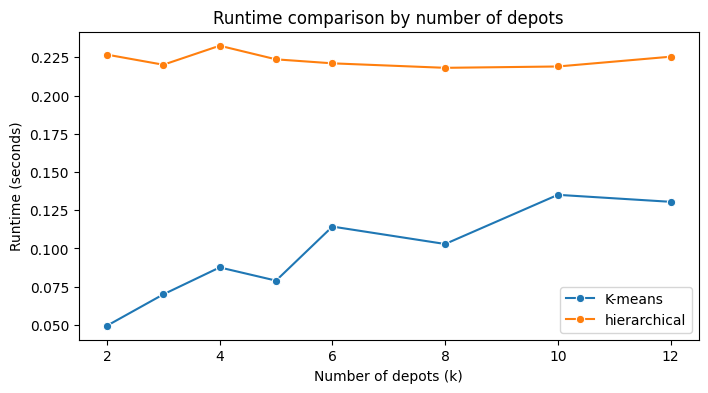

,k,runtime_sec_kmeans,runtime_sec_hier
0,2,0.049472,0.226787
1,3,0.069981,0.220183
2,4,0.087609,0.232620
3,5,0.078972,0.223711
4,6,0.114325,0.221103
5,8,0.102922,0.218162
6,10,0.135089,0.219039
7,12,0.130521,0.225438


In [24]:
# Visual comparison of runtime: k-means vs hierarchical
runtime_compare = kmeans_results[['k', 'runtime_sec']].merge(
    hier_results[['k', 'runtime_sec']], on='k', suffixes=('_kmeans', '_hier')
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=runtime_compare, x='k', y='runtime_sec_kmeans', marker='o', label='K-means')
sns.lineplot(data=runtime_compare, x='k', y='runtime_sec_hier', marker='o', label='hierarchical')
plt.title('Runtime comparison by number of depots')
plt.xlabel('Number of depots (k)')
plt.ylabel('Runtime (seconds)')
plt.show()

runtime_compare

Both k-means and hierarchical clustering identify meaningful service regions that align with the natural separation of customer areas. However, k-means places depot locations more centrally within dense regions making them more suitable as hub coordinates, while hierarchical has a chance of placing them in possibly unrealistic locations (See K = 3 tests above).

The runtime comparison shows that k-means is significantly faster than hierarchical clustering across all tested depot (K) numbers. Although the runtime of k-means increases as k grows, it remains significantly more efficient. Hierarchical clustering exhibits higher computational cost overall, making k-means more scalable for larger numbers of depots.

Overall, k-means provides both better scalability and more directly usable depot locations.

## Product association rule mining

The association rule mining identifies meaningful relationships between product groups, highlighting combinations that are frequently purchased together. High-confidence rules +80% ensure that the observed associations are reliable, while lift-based sorting emphasizes non-random, strongly associated product sets. Products 9 and 19 consistently appear as consequents across multiple rules, suggesting that they act as triggers for purchases of other product groups.

Although some of the highest-lift rules involve rare transaction combinations, the results provide actionable insights for cross-selling, bundling, and targeted promotions. Using confidence thresholds balances reliability with coverage, while support values help focus on rules that impact a significant portion of transactions.

# 6. Deployment

For the depot locations, the company should use the centroids identified by k-means as the coordinates for drone hubs, assigning each customer to the nearest depot to organize deliveries efficiently. Starting with three depots is recommended, and the number can be increased as needed, since k-means remains computationally efficient even when the number of depots grows. 

For product recommendations, the company should focus on promoting products that frequently appear as consequents in high-confidence association rules, particularly Prod9 and Prod19. Bundling products that are commonly purchased together and targeting cross-selling campaigns based on these associations can help increase revenue. Only rules with confidence above 80% and reasonable support should be used for actionable recommendations.